In [466]:
from __future__ import division, print_function
%matplotlib inline
from utils import *
from keras.layers.merge import dot, add, concatenate
from pandas_summary import DataFrameSummary
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

The goal is to predict the next order basket (list of products) for each user in the test set, given info about its prior orders.

# Set up data

Read data

In [2]:
order_products_train_df = pd.read_csv("data/order_products__train.csv")
order_products_prior_df = pd.read_csv("data/order_products__prior.csv")
orders_df = pd.read_csv("data/orders.csv")
products_df = pd.read_csv("data/products.csv")
aisles_df = pd.read_csv("data/aisles.csv")
departments_df = pd.read_csv("data/departments.csv")

Take a peak at the data

In [3]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [4]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [5]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [6]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


Collect order and product info for each user in the training set and then merge into a data frame df

In [7]:
df_train = orders_df.merge(order_products_train_df, how = 'inner', on = 'order_id')
df_train = df_train.merge(products_df, how = 'inner', on = 'product_id')
df_train.sort_values(['user_id', 'order_number'], axis=0, inplace=True)

In [8]:
df_prior = orders_df.merge(order_products_prior_df, how = 'inner', on = 'order_id')
df_prior = df_prior.merge(products_df, how = 'inner', on = 'product_id')
df_prior.sort_values(['user_id', 'order_number'], axis=0, inplace=True)

In [9]:
df = pd.concat([df_prior, df_train])

In [10]:
sample=int(1e5)
df = df.iloc[:sample]

In [11]:
#fillna
df.fillna(0,axis=0, inplace=True)
df.drop('eval_set', axis=1, inplace = True)
df.reset_index(drop = True, inplace = True)
del df_train, df_prior

In [13]:
df.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2539329,1,1,2,8,0.0,196,1,0,Soda,77,7
1,2539329,1,1,2,8,0.0,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16
2,2539329,1,1,2,8,0.0,12427,3,0,Original Beef Jerky,23,19
3,2539329,1,1,2,8,0.0,26088,4,0,Aged White Cheddar Popcorn,23,19
4,2539329,1,1,2,8,0.0,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17


# Engineer new features

## product  list per user

Create new user features encoding order/product info

In [14]:
#separate orders according to their eval_set
prior = orders_df[orders_df["eval_set"]=='prior']
train = orders_df[orders_df["eval_set"]=='train']
test = orders_df[orders_df["eval_set"]=='test']

#get user_ids and the number of users in each eval_set
user_ids_total, n_users_total = prior['user_id'].unique(), prior['user_id'].nunique()
user_ids_train, n_users_train = train['user_id'].unique(), train['user_id'].nunique()
user_ids_test, n_users_test = test['user_id'].unique(), test['user_id'].nunique()

del prior
print("n_users_total = {}, n_users_train = {}, n_users_test = {}".format(n_users_total, n_users_train, n_users_test))

n_users_total = 206209, n_users_train = 131209, n_users_test = 75000


In [15]:
#group by user_id and order_number (this takes ~4 minutes to run locally on the entire data set).
X = df.groupby(['user_id', 'order_number'])['product_id'].apply(lambda x : list(x)).reset_index()
X.columns = ['user_id', 'order_number', 'product_list']

In [16]:
X.head()

,user_id,order_number,product_list
0,1,1,"[196, 14084, 12427, 26088, 26405]"
1,1,2,"[196, 12427, 26088, 10258, 13176, 13032]"
2,1,3,"[196, 12427, 10258, 25133, 30450]"
3,1,4,"[196, 12427, 26405, 10258, 25133]"
4,1,5,"[196, 12427, 10258, 13176, 25133, 10326, 17122..."


In [17]:
from keras.preprocessing.sequence import pad_sequences
sequences = np.array(X.product_list)
maxlen = X.product_list.map(len).max()

# pad sequence
padded = pad_sequences(sequences, padding='post', maxlen= maxlen)

In [18]:
#now group by user_id 
X_users =X.groupby('user_id')['product_list'].apply(lambda x : list(x)).reset_index()
X_users['num_orders_per_user'] = X_users.product_list.map(len)
X_users['ave_num_prods_per_order'] = X_users.product_list.map(lambda L: [len(x) for x in L]).map(np.mean).map(round)
X_users.set_index('user_id',inplace = True)

In [19]:
X_users.head()

,product_list,num_orders_per_user,ave_num_prods_per_order
user_id,,,
1,"[[196, 14084, 12427, 26088, 26405], [196, 1242...",10,6
2,"[[13176, 32792, 47766, 20574, 12000, 48110, 22...",14,14
3,"[[47766, 16797, 9387, 17668, 15143, 39190, 219...",12,7
4,"[[36606, 7350, 35469, 2707], [42329, 7160], [3...",5,4
5,"[[15349, 21413, 48775, 28289, 8518, 11777, 317...",4,9


In [20]:
X_users.iloc[0][0]

[[196, 14084, 12427, 26088, 26405],
 [196, 12427, 26088, 10258, 13176, 13032],
 [196, 12427, 10258, 25133, 30450],
 [196, 12427, 26405, 10258, 25133],
 [196, 12427, 10258, 13176, 25133, 10326, 17122, 41787],
 [196, 12427, 10258, 25133],
 [196, 12427, 10258, 13032, 25133],
 [196, 12427, 10258, 25133, 46149, 49235],
 [196, 12427, 10258, 25133, 46149, 49235],
 [196, 12427, 10258, 13032, 25133, 46149, 39657, 38928, 35951]]

## product rating per user

Create a new product 'rating' score encoding the likelyhood of it being reordered by the user

In [484]:
#drop the first order for each user ('reodered' is meaningless in that case)
df2 = df[df['days_since_prior_order']!=0]

In [485]:
g=df2.groupby(['user_id','product_name','product_id'])

In [491]:
#create prod_rating df and add a product_count feature (i.e. how many times has the user bought the product)
prod_ratings = df2.groupby(['user_id','product_name','product_id'])['reordered'].count().reset_index()
prod_ratings.columns = ['user_id', 'product_name', 'product_id', 'product_count']
prod_ratings.head()

,user_id,product_name,product_id,product_count
0,1,0% Greek Strained Yogurt,38928,1
1,1,Aged White Cheddar Popcorn,26088,1
2,1,Bag of Organic Bananas,13176,2
3,1,Bartlett Pears,41787,1
4,1,Cinnamon Toast Crunch,13032,3


Update product and user ids so that they are contiguous integers, which we want when using embeddings.

In [492]:
users = prod_ratings.user_id.unique()
prods = prod_ratings.product_id.unique()

userid2idx = {o:i for i,o in enumerate(users)}
prodid2idx = {o:i for i,o in enumerate(prods)}

prod_ratings.product_id = prod_ratings.product_id.apply(lambda x: prodid2idx[x])
prod_ratings.user_id = prod_ratings.user_id.apply(lambda x: userid2idx[x])

Apply MinMaxScaler to the 'product_count' column  to get 'product_score'

In [495]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, MinMaxScaler

mapper = DataFrameMapper([('product_count', MinMaxScaler())], df_out=True)

#apply the mapper to each user and concatenate results
dfs = [np.round(mapper.fit_transform(prod_ratings[prod_ratings.user_id==u].copy()), 1) for u in range(n_users)]
    
prod_ratings['product_score'] = pd.concat(dfs).reset_index(drop=True)
prod_ratings.head()

/home/cyrfar/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


,user_id,product_name,product_id,product_count,product_score
0,0,0% Greek Strained Yogurt,0,1,0.0
1,0,Aged White Cheddar Popcorn,1,1,0.0
2,0,Bag of Organic Bananas,2,2,0.1
3,0,Bartlett Pears,3,1,0.0
4,0,Cinnamon Toast Crunch,4,3,0.3


In [497]:
n_users = prod_ratings.user_id.nunique()
n_prods = prod_ratings.product_id.nunique()

n_users, n_prods

(667, 11864)

This is the number of latent factors in each embedding.

In [498]:
n_factors = 50

In [499]:
np.random.seed = 42

Randomly split into training and validation.

In [500]:
msk = np.random.rand(len(prod_ratings)) < 0.8
trn = prod_ratings[msk]
val = prod_ratings[~msk]

#  Simple Model using embeddings in Keras

In [521]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(input_dim=n_in, output_dim=n_out, input_length=1, embeddings_regularizer=l2(reg))(inp)

In [522]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-3)
prod_in, p = embedding_input('prod_in', n_prods, n_factors, 1e-3)

In [523]:
def create_bias(inp, n_in):
    x = Embedding(input_dim=n_in, output_dim=1, input_length=1)(inp)
    return Flatten()(x)

In [524]:
ub = create_bias(user_in, n_users)
pb = create_bias(prod_in, n_prods)

In [525]:
x = dot([u, p], axes=2)
x = Flatten()(x)
x = add([x, ub])
x = add([x, pb])
model = Model([user_in, prod_in], x)
model.compile(Adam(0.001), loss='mse', metrics=['accuracy'])

In [526]:
model.fit([trn.user_id, trn.product_id], trn.product_score, batch_size=64, epochs=2, 
          validation_data=([val.user_id, val.product_id], val.product_score))

Train on 31025 samples, validate on 7675 samples
Epoch 1/2
31025/31025 [==============================] - 7s - loss: 0.7403 - acc: 0.6572 - val_loss: 0.1291 - val_acc: 0.6520
Epoch 2/2
31025/31025 [==============================] - 7s - loss: 0.1272 - acc: 0.6572 - val_loss: 0.1252 - val_acc: 0.6520


In [512]:
model.optimizer.lr=0.01

In [513]:
model.fit([trn.user_id, trn.product_id], trn.product_score, batch_size=64, epochs=2, 
          validation_data=([val.user_id, val.product_id], val.product_score))

Train on 31025 samples, validate on 7675 samples
Epoch 1/2
31025/31025 [==============================] - 8s - loss: 0.0387 - acc: 0.6582 - val_loss: 0.0508 - val_acc: 0.6520
Epoch 2/2
31025/31025 [==============================] - 9s - loss: 0.0379 - acc: 0.6582 - val_loss: 0.0509 - val_acc: 0.6517


In [514]:
model.optimizer.lr=0.001

In [515]:
model.fit([trn.user_id, trn.product_id], trn.product_score, batch_size=64, epochs=2, 
          validation_data=([val.user_id, val.product_id], val.product_score))

Train on 31025 samples, validate on 7675 samples
Epoch 1/2
31025/31025 [==============================] - 9s - loss: 0.0373 - acc: 0.6584 - val_loss: 0.0511 - val_acc: 0.6517
Epoch 2/2
31025/31025 [==============================] - 9s - loss: 0.0369 - acc: 0.6587 - val_loss: 0.0514 - val_acc: 0.6516


In [511]:
model.fit([trn.user_id, trn.product_id], trn.product_score, batch_size=4, epochs=1, 
          validation_data=([val.user_id, val.product_id], val.product_score))

Train on 31025 samples, validate on 7675 samples
Epoch 1/1
31025/31025 [==============================] - 147s - loss: 0.0428 - acc: 0.6573 - val_loss: 0.0509 - val_acc: 0.6521


In [516]:
model.save_weights('models/simplemodel3.h5')

In [527]:
model.load_weights('models/simplemodel3.h5')

# Recommend products to a given user

First, construct a product_id to product_name dictionary

In [528]:
prodid2prodname = {i:j for i,j in zip(prod_ratings.product_id,prod_ratings.product_name)}

and a helper function to predict new product scores

In [537]:
def predictions(user_id, product_id):
    '''create a product_name:product_score dictionary '''
    return (prodid2prodname[product_id], np.round(model.predict([np.array([user_id]), np.array([product_id])]),1)[0][0])

#def user_product_zip(user_id):
#    '''zip a given user_id with each product available'''
#    return zip(np.ones(n_prods, dtype=np.int)*user_id, np.array(range(n_prods)))

In [539]:
#the model predicts that user 0 is likely to order product 14 (soda), as expected! 
predictions(0,14)

('Soda', 0.30000001)

Recommend a list of product to a given user, using the top predicted product_scores

In [548]:
def user_recommendation(user_id):
    scores = {predictions(user_id,p)[0]:predictions(user_id,p)[1] for p in range(n_prods)}
    return list(OrderedDict(sorted(scores.items(), key =itemgetter(1), 
                                   reverse = True)))[:X_users.ave_num_prods_per_order.iloc[user_id]]

In [549]:
user_recommendation(45)

['Organic Apple Banana GoGo Squeez',
 'Lactose Free Fat Free Milk',
 'Smartwater',
 '2% Reduced Fat Organic Milk',
 'Petit Suisse Fruit',
 'Organic Reduced Fat Omega-3 Milk',
 'Mozzarella Ciliegine',
 'Bag of Organic Bananas']

In [545]:
prod_ratings[prod_ratings.user_id==45].sort_values(['product_score'], ascending=[False])[:X_users.ave_num_prods_per_order.iloc[45]]

,user_id,product_name,product_id,product_count,product_score
2533,45,Krinkle Cut Salt & Fresh Ground Pepper Potato ...,1065,12,1.0
2514,45,Banana,22,11,0.9
2551,45,Reduced Fat 2% Lactose-Free Milk,1934,6,0.5
2519,45,Chubby Hubby Ice Cream,1914,6,0.5
2550,45,Red Potatoes,1933,7,0.5
2516,45,Cajun Andouille Smoked Pork Sausage,1320,5,0.4
2518,45,Chocolate Chocolate Chip Ice Cream,1913,5,0.4
2545,45,Organic Large Grade A Brown Eggs,1498,5,0.4


# Analyze results

For simplicity, we restrict the analysis to the top 2000 most popular products.

In [550]:
g=prod_ratings.groupby('product_id')['product_score'].count()
topProds=g.sort_values(ascending=False)[:2000]
topProds = np.array(topProds.index)

In [551]:
topProds

array([  22,    2,  136, ..., 4322, 5605, 4463])

Let us first look at the product bias term. We create a model using the functional API. Our input is the product id and the output is the product bias term.

In [552]:
prod_names = prod_ratings['product_name'].to_dict

In [553]:
#top product is banana
prod_names()[topProds[0]]

'Banana'

In [554]:
prod_bias[0]

array([ 0.8336], dtype=float32)

In [556]:
get_prod_bias = Model(prod_in, pb)
prod_bias = get_prod_bias.predict(topProds)
product_ratings = [(b[0], prod_names()[prod_ratings.product_id[i]]) for i,b in zip(topProds,prod_bias)]

Now we can look at the top and bottom rated products. These ratings take into account user sentiment, as well as different types of producst that different users reorder.

In [557]:
sorted(product_ratings, key=itemgetter(0))[:15]

[(-0.21366367, 'Balsamic Vinegar Of Modena'),
 (-0.1834068, 'Canned Aranciata Orange'),
 (-0.1794337, 'Organic Small Bunch Celery'),
 (-0.1694783,
  'Light and Lean Quinoa Black Beans with Butternut Squash and Chard'),
 (-0.1667304, 'Electrolyte Water'),
 (-0.16437213, 'Organic Rice Vinegar'),
 (-0.16307753, 'Anaheim Pepper'),
 (-0.16059639, 'Carrots'),
 (-0.15949398, 'Paper Towel'),
 (-0.15885305, 'Dairy Free Vanilla Coconut Milk'),
 (-0.1577832, 'Whole Young Chicken'),
 (-0.15704456, 'Organic Baby Bella Mushrooms'),
 (-0.15497383, 'Lentils'),
 (-0.15397248, 'Organic Dark Chocolate Pomegranate Trail Mix Bar'),
 (-0.1538759, 'Organic Red Onion')]

In [558]:
sorted(product_ratings, key=itemgetter(0), reverse=True)[:15]

[(0.42889512, 'Saltine Crackers'),
 (0.41697171, 'Dairy Pure Heavy Whipping Cream'),
 (0.41183451, 'Mini Double Caramel Ice Cream Bars'),
 (0.35925785, '12 Oz Lager'),
 (0.31777117, 'Sliced Portabella Mushrooms'),
 (0.31181747, 'Shredded Mild Cheddar Cheese'),
 (0.28913239, 'Hot Dog Buns'),
 (0.28866014, 'Drumstick Variety Pack Frozen Dairy Dessert Cones'),
 (0.28238708, 'Organic Eggplant'),
 (0.27660701, 'Organic Large Grade A Brown Eggs'),
 (0.27657452,
  'Tender white meat chicken in a red chile lime sauce with a medley of roasted corn, peppers, and rice Chile Lime Chicken'),
 (0.27541903, '3 in 1 Can Opener'),
 (0.27516493, 'Bag of Organic Bananas'),
 (0.27486482, 'Banana'),
 (0.27417022, 'Creamy Peanut Butter')]

We can now do the same thing for the embeddings.

In [559]:
get_prod_emb = Model(prod_in, p)
prod_emb = np.squeeze(get_prod_emb.predict([topProds]))
prod_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [560]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
prod_pca = pca.fit(prod_emb.T).components_

In [561]:
fac0 = prod_pca[0]

In [562]:
prod_comp = [(f, prod_names()[prod_ratings.product_id[i]]) for f,i in zip(fac0, topProds)]

Here's the 1st component. Hard to tell what these features represent...

In [563]:
sorted(prod_comp, key=itemgetter(0), reverse=True)[:10]

[(0.52054778589935224, 'Organic American Cheese Singles'),
 (0.36162366543527369, 'Grape White/Green Seedless'),
 (0.19701462737598704, 'Smooth Operator Natural Peanut Butter'),
 (0.10541503209392442, 'Total 2% Lowfat Greek Strained Yogurt With Blueberry'),
 (0.099376102418071585, 'Veggie Loaf & Mashed Potatoes Entrée'),
 (0.090835993276113622, 'Electrolyte Water'),
 (0.068525937470094903, 'Chopped Tomatoes'),
 (0.045125920637004331, 'Organic Russet Potato'),
 (0.042170645891914493, 'Organic Cucumber'),
 (0.041803344196130771, 'Banana')]

In [564]:
sorted(prod_comp, key=itemgetter(0))[:10]

[(-0.6042027755134145, 'Dark Chocolate Mint Snacking Chocolate'),
 (-0.1989779915230194, 'Yellow Onions'),
 (-0.188835834225553, 'Organic Yams'),
 (-0.12033290544271767, 'All Natural Marinara Sauce'),
 (-0.085504788130442863, 'Organic Pure Lime Juice'),
 (-0.079632187384065509, 'Chicken Quesadilla'),
 (-0.071976906253977124, 'Original No Pulp 100% Florida Orange Juice'),
 (-0.06464139824783087, 'Organic Granny Smith Apple'),
 (-0.064409577517227271, 'Semi-Soft Cheese, Ripened'),
 (-0.057872980932903585, 'Total 2% Greek Strained Yogurt with Cherry 5.3 oz')]

In [565]:
fac1 = prod_pca[1]

In [566]:
prod_comp = [(f, prod_names()[prod_ratings.product_id[i]]) for f,i in zip(fac1, topProds)]

Here's the 2nd component

In [567]:
sorted(prod_comp, key=itemgetter(0), reverse=True)[:10]

[(0.48955827405148411, 'Organic American Cheese Singles'),
 (0.30355944136162161, 'Dark Chocolate Mint Snacking Chocolate'),
 (0.19126272034349925, 'Total 2% Lowfat Greek Strained Yogurt With Blueberry'),
 (0.16521970805594918, 'Smooth Operator Natural Peanut Butter'),
 (0.12046523734514913, 'Organic Spring Mix'),
 (0.1043630208408456, 'Chopped Tomatoes'),
 (0.065477804574812434, 'Organic Cucumber'),
 (0.060619049500515713, 'Liquid Hand Soap, Refill, Lavender Scent'),
 (0.059970092463600889, 'Special Reserve Extra Sharp Cheddar Cheese'),
 (0.056085793229359485, 'Organic Large Brown Grade AA Cage Free Eggs')]

In [568]:
sorted(prod_comp, key=itemgetter(0))[:10]

[(-0.62291350711854476, 'Grape White/Green Seedless'),
 (-0.17767306888171608, 'Original No Pulp 100% Florida Orange Juice'),
 (-0.1643988754182367, 'Total 2% Greek Strained Yogurt with Cherry 5.3 oz'),
 (-0.14429707557454488, 'Organic Yams'),
 (-0.10725771272132743, 'Yellow Onions'),
 (-0.085195385501233942, 'Veggie Loaf & Mashed Potatoes Entrée'),
 (-0.083371362778081465, 'All Natural Marinara Sauce'),
 (-0.081494244349031644, 'Maple Almond Butter'),
 (-0.069918175163744836, 'Organic Pure Lime Juice'),
 (-0.067196952094884466, 'Chicken Quesadilla')]

In [569]:
fac2 = prod_pca[2]

In [570]:
prod_comp = [(f, prod_names()[prod_ratings.product_id[i]]) for f,i in zip(fac2, topProds)]

Here's the 3rd component

In [571]:
sorted(prod_comp, key=itemgetter(0), reverse=True)[:10]

[(0.091484175115052482, 'Organic Yams'),
 (0.089936319387768054,
  'Turkey sausage with egg whites and reduced fat cheese on an English muffin Turkey Sausage English Muffin'),
 (0.072216978115790004, 'Yellow Onions'),
 (0.071008662870685232, 'Uncured Genoa Salami'),
 (0.061038123456697103, 'Total 2% Greek Strained Yogurt with Cherry 5.3 oz'),
 (0.049400330805481098, 'Antioxidant Infusions Ipanema Pomegranate Beverage'),
 (0.047862856137999427, 'HE Original Liquid Laundry Detergent'),
 (0.047496846497294333,
  'Freshly made pasta layered between a rich meat sauce and topped with Real Mozzarella cheese Lasagna with Meat & Sauce'),
 (0.04134599344684816, 'Natural California Raisins'),
 (0.040015685651783879, 'Half & Half')]

In [572]:
sorted(prod_comp, key=itemgetter(0))[:10]

[(-0.58147317399406984, 'Dark Chocolate Mint Snacking Chocolate'),
 (-0.5499819404196028, 'Grape White/Green Seedless'),
 (-0.33715817236169299, 'Semi-Soft Cheese, Ripened'),
 (-0.26096380478605119, 'Organic American Cheese Singles'),
 (-0.12853981380719501, 'Organic Pure Lime Juice'),
 (-0.11959847415163528, 'Smooth Operator Natural Peanut Butter'),
 (-0.10585567776629898, 'Whole Milk'),
 (-0.088380102858956325, 'Premium Indian Tonic Water'),
 (-0.083342320103291706, 'Gold?! Ice Cream Bars'),
 (-0.059562825469643275, 'Fettuccini with Chicken Broccoli')]

We can draw a picture to see how various products appear on the map of these components. This picture shows the 1st and 3rd components.

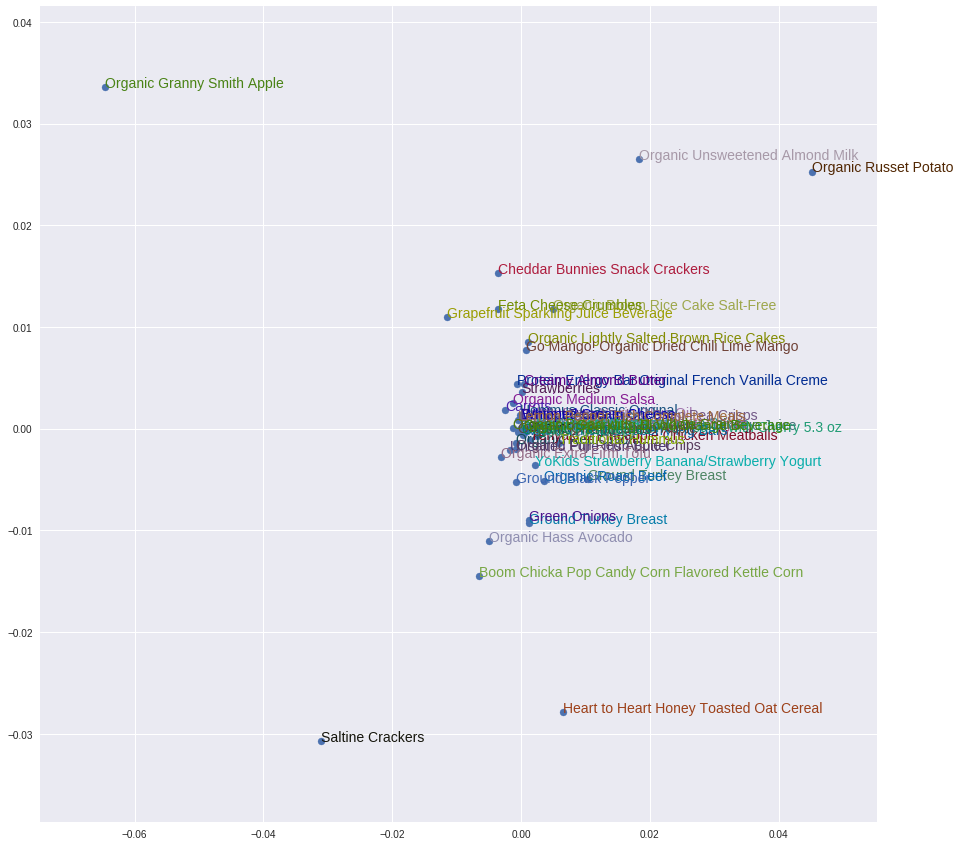

In [573]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topProds[start:end], X, Y):
    plt.text(x,y,prod_names()[prod_ratings.product_id[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()